# Creating a XGBoost model slowly

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pandas


In [2]:
import sys
import os

sys.path.append(os.path.abspath("../scripts"))

from load_data import load_data

## Load Data

### Start with smaller dataset

### 3/6/24 - A8 Channels from Selva
- **Number of Cycles**: ~50
- **Details**:
  - Channels: A1 to A8
  - High C-Rate
  - Room Temperature (25 °C)

In [14]:
df = load_data("03-06-24", "A1.csv")

## Preprocess

In [15]:
df = df.dropna()

# fix reading column issue
if "#NAME?" in df.columns.values : df = df.rename(columns={"#NAME?": "Im(Z)/Ohm"})

# Apply filtering
df = df.loc[(df['cycle number'] != 0)].copy()
# df = df.loc[(df['Ns'].isin([1, 6])) & (df['cycle number'] != 0)].copy()

In [16]:
df.columns.values

array(['mode', 'ox/red', 'error', 'control changes', 'Ns changes',
       'counter inc.', 'Ns', 'I Range', 'time/s', 'control/V/mA',
       'Ecell/V', 'I/mA', 'dq/mA.h', '(Q-Qo)/mA.h', '|Energy|/W.h',
       'freq/Hz', '|Z|/Ohm', 'Phase(Z)/deg', 'Q charge/discharge/mA.h',
       'half cycle', 'Energy charge/W.h', 'Energy discharge/W.h',
       'Capacitance charge/µF', 'Capacitance discharge/µF', 'step time/s',
       'z cycle', 'Re(Z)/Ohm', 'Im(Z)/Ohm', 'Re(Y)/Ohm-1', 'Im(Y)/Ohm-1',
       '|Y|/Ohm-1', 'Phase(Y)/deg', 'x', 'Q discharge/mA.h',
       'Q charge/mA.h', 'Capacity/mA.h', 'Efficiency/%', 'control/V',
       'control/mA', 'cycle number', 'P/W', 'R/Ohm'], dtype=object)

In [17]:
capacity = df['Capacity/mA.h']
cycle_number = df['cycle number']

### Confirm Degradation

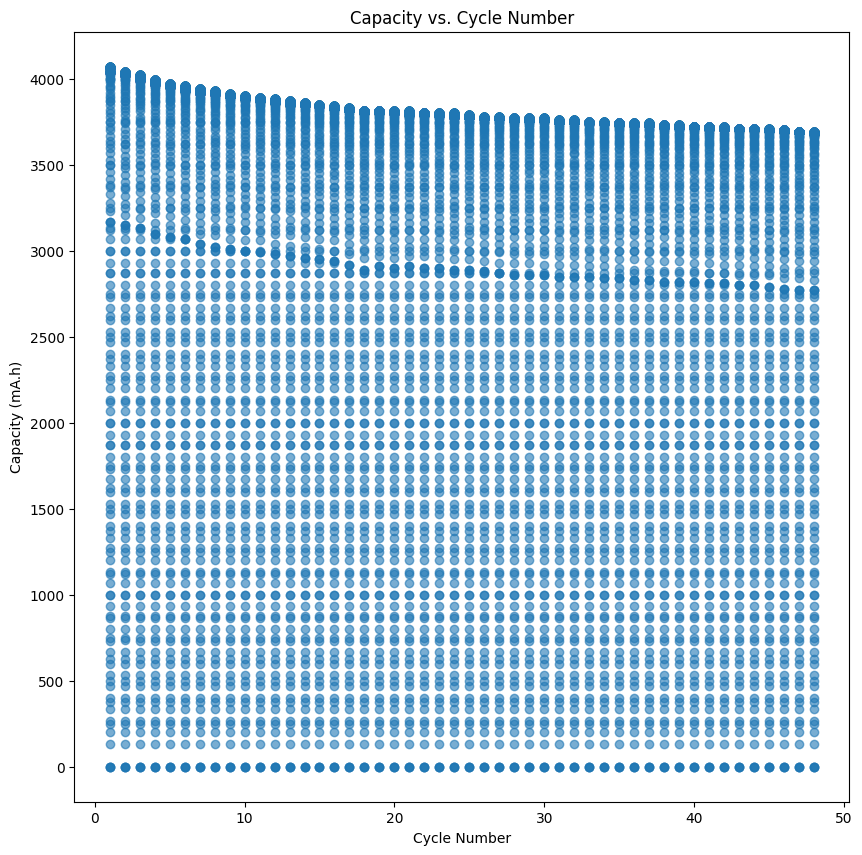

In [18]:
plt.figure(figsize=(10, 10))
plt.scatter(cycle_number, capacity, alpha=0.6)
plt.xlabel('Cycle Number')
plt.ylabel('Capacity (mA.h)')
plt.title('Capacity vs. Cycle Number')
plt.show()

#### Important note: degradation is not visible unless we filter for just the states that EIS is being performed

## Building the Input
### We need a state and action vector

### State Vector $s_{n}$ - concatenated impedance values at 57 different frequencies 0.02Hz - 20kHz

In [8]:
df['freq/Hz'].min()

np.float64(0.00931)

In [9]:
df['freq/Hz'].max()

np.float64(10000.0)

### We don't have the same range of frequencies in our data. Our data ranges from .00931Hz to 10kHz

### Must make state vector FOR EACH CYCLE

In [19]:
# Dictionary to store all data by cycle, keyed by cycle number.
all_data_by_cycle = {}

# Get all unique cycle numbers
all_cycles = df['cycle number'].unique()

for cycle in sorted(all_cycles):
    # 1) Slice the dataframe for only this cycle
    df_cycle = df[df['cycle number'] == cycle].copy()

    # 2) Sort by frequency (ascending)
    df_cycle_sorted = df_cycle.sort_values(by='freq/Hz', ascending=True)

    # 3) Extract frequency, real part, and imaginary part
    freq_values = df_cycle_sorted['freq/Hz'].values
    Z_re_sorted = df_cycle_sorted['Re(Z)/Ohm'].values
    Z_im_sorted = df_cycle_sorted['Im(Z)/Ohm'].values

    # 4) Build a dictionary that labels each frequency's real/imag parts
    labeled_entries = {}
    for i, freq in enumerate(freq_values):
        freq_str = f"{freq:.5g}"  # e.g. "0.01", "100", etc.
        labeled_entries[f"Z_re({freq_str}Hz)"] = Z_re_sorted[i]
        labeled_entries[f"Z_im({freq_str}Hz)"] = Z_im_sorted[i]

    # 5) Build the flattened state vector for ML: 
    #    [Z_re(w1), Z_im(w1), Z_re(w2), Z_im(w2), ..., Z_re(wN), Z_im(wN)]
    state_vector = np.concatenate([Z_re_sorted, Z_im_sorted])

    # 6) Store both in a dictionary keyed by cycle
    all_data_by_cycle[cycle] = {
        "labeled_data": labeled_entries,
        "state_vector": state_vector
    }


In [20]:
# Now let's inspect the results for a couple of cycles:
for cycle in sorted(all_data_by_cycle.keys())[:2]:
    data_for_cycle = all_data_by_cycle[cycle]
    labeled_dict = data_for_cycle["labeled_data"]
    vec = data_for_cycle["state_vector"]
    
    print(f"\nCycle {cycle}:")
    print(f"  Number of labeled entries: {len(labeled_dict)}")
    # Print a few example labeled entries (keys and values)
    some_keys = list(labeled_dict.keys())[:6]
    for k in some_keys:
        print(f"    {k} = {labeled_dict[k]}")
    print(f"  State vector length = {len(vec)}")
    print(f"  First 6 elements of state vector: {vec[:6]}")



Cycle 1.0:
  Number of labeled entries: 162
    Z_re(0Hz) = 0.0
    Z_im(0Hz) = 0.0
    Z_re(0.00931Hz) = 0.0382
    Z_im(0.00931Hz) = 0.0607
    Z_re(0.014Hz) = 0.0382
    Z_im(0.014Hz) = 0.0431
  State vector length = 598
  First 6 elements of state vector: [0. 0. 0. 0. 0. 0.]

Cycle 2.0:
  Number of labeled entries: 162
    Z_re(0Hz) = 0.0
    Z_im(0Hz) = 0.0
    Z_re(0.00931Hz) = 0.0414
    Z_im(0.00931Hz) = 0.0571
    Z_re(0.014Hz) = 0.0363
    Z_im(0.014Hz) = 0.0432
  State vector length = 598
  First 6 elements of state vector: [0. 0. 0. 0. 0. 0.]


1. A **labeled** dictionary (for human readability) that maps each frequency to its real and imaginary impedance parts.  
2. An **unlabeled** (flattened) state vector suitable for input into a machine learning model.  

We'll do this **per cycle** and store everything in a single dictionary, keyed by the cycle number.

## Explanation

1. **Group by Cycle**  
   - We identify each unique cycle in `df['cycle number']`.  
2. **For Each Cycle**  
   - **Sort** the subset of rows by `freq/Hz`.  
   - Extract arrays for frequency (`freq_values`), real impedance (`Z_re_sorted`), and imaginary impedance (`Z_im_sorted`).  
3. **Build a Labeled Dictionary**  
   - We map each frequency to `Z_re(freq)` and `Z_im(freq)` for readability.  
   - This is helpful for debugging or when you need to check exact values at a certain frequency.  
4. **Build the Flattened State Vector**  
   - By concatenating real parts (in ascending frequency order) followed immediately by the imaginary parts, we get a vector with length \(2 \times N\), where \(N\) is the number of frequency points for that cycle.  
   - This vector is typically what you would feed into a machine learning model.  
5. **Store Both** in a single dictionary, keyed by `cycle`:  
   - `all_data_by_cycle[cycle]["labeled_data"]` for human readability.  
   - `all_data_by_cycle[cycle]["state_vector"]` for ML.  

When you train a model, you’ll likely iterate through each cycle, grab `state_vector`, and pair it with the corresponding **action** (the charging/discharging protocol for that cycle) and **target** (`Q_n`, the capacity at the end of the cycle).

---

## Key Points

- **Consistency**: Ensure each cycle has the **same** set (or the same number) of frequencies if you want your ML input vectors to align properly across all cycles. If not, you may need **interpolation** to a common frequency grid.  
- **Potential Memory Trade-off**: Storing a labeled dictionary for every frequency can be memory-intensive if you have many cycles. If memory becomes an issue, you can omit it after debugging, or store it separately.  
- **Ready for ML**: The `state_vector` is your direct input into a neural network, random forest, or other regression model—just keep track of the shape (e.g., 162 elements per cycle, in your example).  

In [21]:
all_data_by_cycle

{np.float64(1.0): {'labeled_data': {'Z_re(0Hz)': np.float64(0.0),
   'Z_im(0Hz)': np.float64(0.0),
   'Z_re(0.00931Hz)': np.float64(0.0382),
   'Z_im(0.00931Hz)': np.float64(0.0607),
   'Z_re(0.014Hz)': np.float64(0.0382),
   'Z_im(0.014Hz)': np.float64(0.0431),
   'Z_re(0.0186Hz)': np.float64(0.0331),
   'Z_im(0.0186Hz)': np.float64(0.0341),
   'Z_re(0.0233Hz)': np.float64(0.0327),
   'Z_im(0.0233Hz)': np.float64(0.0275),
   'Z_re(0.0326Hz)': np.float64(0.0301),
   'Z_im(0.0326Hz)': np.float64(0.0214),
   'Z_re(0.0442Hz)': np.float64(0.0281),
   'Z_im(0.0442Hz)': np.float64(0.0166),
   'Z_re(0.0582Hz)': np.float64(0.0267),
   'Z_im(0.0582Hz)': np.float64(0.0137),
   'Z_re(0.0792Hz)': np.float64(0.0256),
   'Z_im(0.0792Hz)': np.float64(0.0109),
   'Z_re(0.105Hz)': np.float64(0.0246),
   'Z_im(0.105Hz)': np.float64(0.00869),
   'Z_re(0.142Hz)': np.float64(0.0237),
   'Z_im(0.142Hz)': np.float64(0.00709),
   'Z_re(0.189Hz)': np.float64(0.0231),
   'Z_im(0.189Hz)': np.float64(0.00594),
  

### Action Vector building

# VERY IMPORTANT NOTES FOR NICK

### filtering out NS= 1,6 is the EIS data which is good for building the state vector, however when building the action vector we would want all of the information 